In [1]:
# imports
import pandas as pd
import numpy as np
import findiff
from os import listdir
from sklearn.manifold import MDS
from scipy.stats import wasserstein_distance as wd
from matplotlib import pyplot as plt
import seaborn as sns         
from mvlearn.embed import MVMDS
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
annotations = pd.read_excel('Japanese_Label.xls')
upset_files =annotations.loc[annotations['Japanese Label']== 'Upset', 'Filename']
happy_files =annotations.loc[annotations['Japanese Label']== 'Happy', 'Filename']
angry_files =annotations.loc[annotations['Japanese Label']== 'Angry', 'Filename']
sad_files =annotations.loc[annotations['Japanese Label']== 'Sad', 'Filename']
joyful_files =annotations.loc[annotations['Japanese Label']== 'Joyful', 'Filename']
surprised_files =annotations.loc[annotations['Japanese Label']== 'Surprised', 'Filename']
depresed_files =annotations.loc[annotations['Japanese Label']== 'Depressed', 'Filename']
fearful_files =annotations.loc[annotations['Japanese Label']== 'Fearful', 'Filename']

In [10]:
jp =annotations.iloc[:,1]

In [12]:
annotation= pd.read_excel('US_Label.xls')
upset_files_us=annotation.loc[annotation['US Label']== 'Upset', 'Filename']
happy_files_us =annotation.loc[annotation['US Label']== 'Happy', 'Filename']
angry_files_us =annotation.loc[annotation['US Label']== 'Angry', 'Filename']
sad_files_us =annotation.loc[annotation['US Label']== 'Sad', 'Filename']
joyful_files_us =annotation.loc[annotation['US Label']== 'Joyful', 'Filename']
surprised_files_us =annotation.loc[annotation['US Label']== 'Surprised', 'Filename']
depresed_files_us =annotation.loc[annotation['US Label']== 'Depressed', 'Filename']
fearful_files_us =annotation.loc[annotation['US Label']== 'Fearful', 'Filename']

In [14]:
us = annotation.iloc[:,1]

In [16]:
conf = confusion_matrix(jp,us)
print(conf)

[[16  0  0  3  0  0  1  5]
 [ 0 11  0  0  0  3  0  2]
 [ 0  0  8  0  0  0  1  0]
 [ 0  0  0  9  0  0  0  0]
 [ 0  0  0  5  6  0  3  0]
 [ 0  4  0  0  0  0  0  0]
 [ 1  1  4  4  0  0 12  2]
 [ 3  3  0  0  0  3  0  2]]


In [12]:
def calculate_similarity(series1, series2):
    set1 = set(series1)
    set2 = set(series2)
    
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    jaccard_similarity = len(intersection) / len(union)
    agreement_percentage = jaccard_similarity * 100
    
    return agreement_percentage


In [13]:
calculate_similarity(fearful_files,fearful_files_us)

61.53846153846154

#### The similarity between japanese and american annotations on fearfull emotion is 61.54 % 

In [14]:
calculate_similarity(sad_files_us,sad_files)

0.0

#### The similarity between japanese and american annotations on sad emotion is 0 %, they don't agree in this emotion.

In [16]:
calculate_similarity(happy_files_us,happy_files)

42.857142857142854

#### The similarity between japanese and american annotations on happy emotion is 42.86 % 

In [17]:
calculate_similarity(angry_files_us,angry_files)

55.172413793103445

#### The similarity between japanese and american annotations on angry emotion is 55.17 % 

In [18]:
calculate_similarity(surprised_files_us,surprised_files)

41.37931034482759

#### The similarity between japanese and american annotations on surprised emotion is 41.38 % 

In [19]:
calculate_similarity(upset_files_us,upset_files)

10.0

#### The similarity between japanese and american annotations on upset emotion is 10 % 

In [20]:
calculate_similarity(depresed_files_us,depresed_files)

45.83333333333333

#### The similarity between japanese and american annotations on depresed emotion is 45.83 % 

In [21]:
calculate_similarity(joyful_files_us,joyful_files)

42.857142857142854

#### The similarity between japanese and american annotations on joyfull emotion is 42.86 % 

In [5]:
with open("folder_96_columns/FA4_10-7.csm",'r') as f:
    tmp1 =f.readlines()[13]
tmp1 = tmp1.split(' ')[:-1]
header2= []
for i in tmp1:
    header2.append(i+"_x")
    header2.append(i+"_y")
    header2.append(i+"_z")
len(header2)

96

In [24]:
tmps = listdir("acted1")
len(tmps)

111

In [6]:


tmps = listdir("acted1")

distributions=[]
for tmp in tmps:
    #read data
    try:
        data = pd.read_csv("acted1/"+tmp,skiprows=17,sep="  ",index_col=0,header=None,engine='python')
        # data = data.drop(columns=data.columns[-1]) #delete useless NA filled last column
    except pd.errors.ParserError: #contains "DROPOUT" as values for some sensors at the end, separated with spaces and not tabs, which messes up the parsins 
        data = pd.read_csv("acted1/"+tmp,skiprows=17,sep="  ",index_col=0,header=None, engine='python')
# data.shape[1]
    if data.shape[1] == 102:
        data = data.drop(data.columns[-6:], axis=1)
# data.shape
    data.columns = header2

    # grad of each column
    dt = 1/60 # distance between two frames is (1/60)s
    grad=findiff.Gradient(h=[dt])
    vitesses=[] #liste rad vitesse inst
    for col in range(len(data.columns)):
        d = np.array(data[data.columns[col]])
        v = grad(d)
        vitesses.append(v[0])
    
    #processing distribution for each column (result of hist are couples (distribution,bins), so we take only the first part of the hist)
    distribution = []
    for v in vitesses:
        distribution.append(np.histogram(v,bins=101,range=[0,500])[0])
    
    distributions.append(distribution)

In [7]:
#processing the wassenstein distances and making the distance matrix for MDS (! for the first captor !)
nb_mvt = len(tmps) #nombre de mouvements
nb_sensors = len(distributions[0])
Xs = []

for k in range(nb_sensors):
    w_dist=np.empty((nb_mvt,nb_mvt))
    for i in range(nb_mvt):
        w_dist[i][i]=0
        for j in range(i+1,nb_mvt):
            w_dist[i][j] = w_dist[j][i] = wd(distributions[i][k],distributions[j][k])
    Xs.append(w_dist)
        
print(len(Xs))


96


<h3>Now we use the Xs to calculate a 2D array to represent the similarities between the mouvements in the variable pts ( plus a part of the code to save / read the value of pts)

In [66]:
from sklearn.manifold import TSNE
pts=TSNE().fit_transform(Xs[1])

In [8]:
#using MVMDS
mds = MVMDS(dissimilarity='precomputed')
pts = mds.fit_transform(Xs)
mds.__dict__

{'components_': array([[-5.87186505e-02, -2.23482586e-02],
        [-1.46937089e-02, -5.06748461e-02],
        [-5.89875054e-02,  5.95519749e-02],
        [-5.00292176e-02, -3.99067612e-02],
        [-5.75357956e-02,  6.69312460e-02],
        [-5.89989130e-02,  7.84832002e-02],
        [-5.09796176e-02, -1.76241287e-02],
        [-6.27646158e-02, -6.06183321e-02],
        [-6.64326276e-02, -3.01175683e-02],
        [-6.08760450e-02,  4.15669630e-02],
        [-4.13555979e-02,  5.48682278e-02],
        [-5.99344796e-02, -2.89263495e-02],
        [-4.19160232e-02, -6.15105716e-02],
        [-6.11394538e-02, -2.01386957e-02],
        [-7.02021240e-02,  4.05443642e-02],
        [-5.74789415e-02,  3.28873535e-03],
        [-4.29769149e-02, -1.02189503e-02],
        [-4.20155345e-02,  6.18582526e-02],
        [-5.54131655e-02,  3.52116568e-02],
        [-6.73532384e-02,  3.75067625e-02],
        [-8.16792778e-02,  1.80168555e-02],
        [-4.55655792e-02,  1.25266727e-02],
        [-6.05676

<h1> Visualisation

In [68]:
pts.shape

(111, 2)

In [69]:
tmps = listdir("acted1")
len(tmps)

111

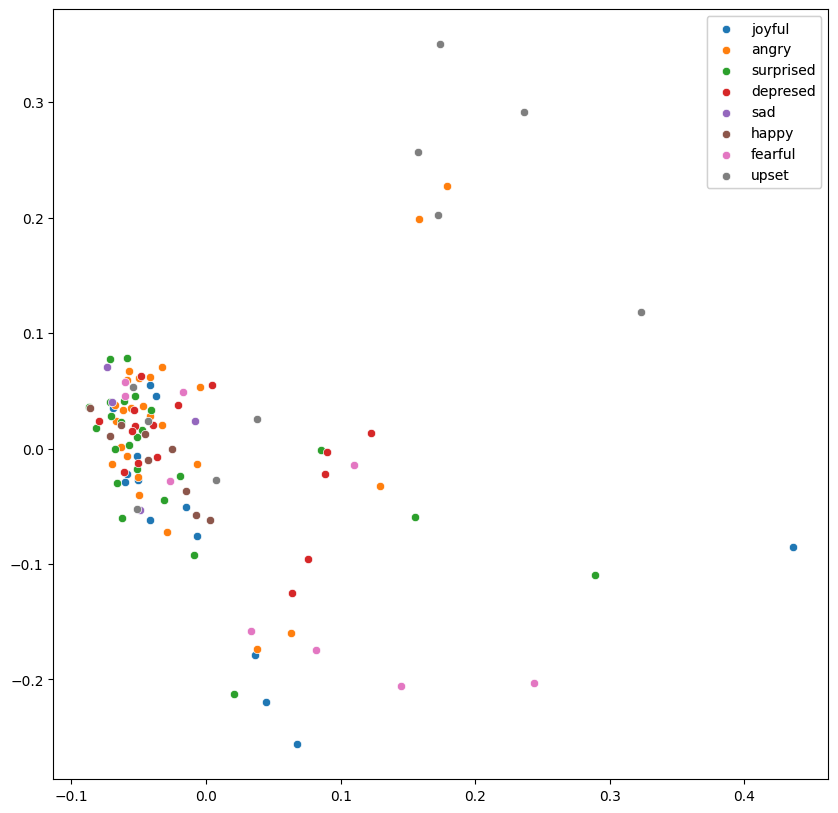

In [72]:
tmps = listdir("acted1") # current directory

#grp = { 'emotion' : [ [x1,x2] , [y1,y2] , color ] , ...}
grp = {}
for i in range(len(tmps)):
    tmp = tmps[i].split("_") # list of all names of files where are seperated by _
    #['ale', 'lift', 'an', '1', 'fin.csm']
    
    if tmp[-2] not in grp.keys():
         grp[tmp[-2]]=[[],[]]
    grp[tmp[-2]][0].append(pts[i][0])
    grp[tmp[-2]][1].append(pts[i][1])
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1])
legend1 = ax.legend(grp.keys())
ax.add_artist(legend1)

<h1> Kmean and visualisation

In [9]:
kmeans = KMeans( n_clusters=8,random_state=0).fit(pts)
clusters = kmeans.labels_

c:\Users\DELL\anaconda3\envs\IMS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


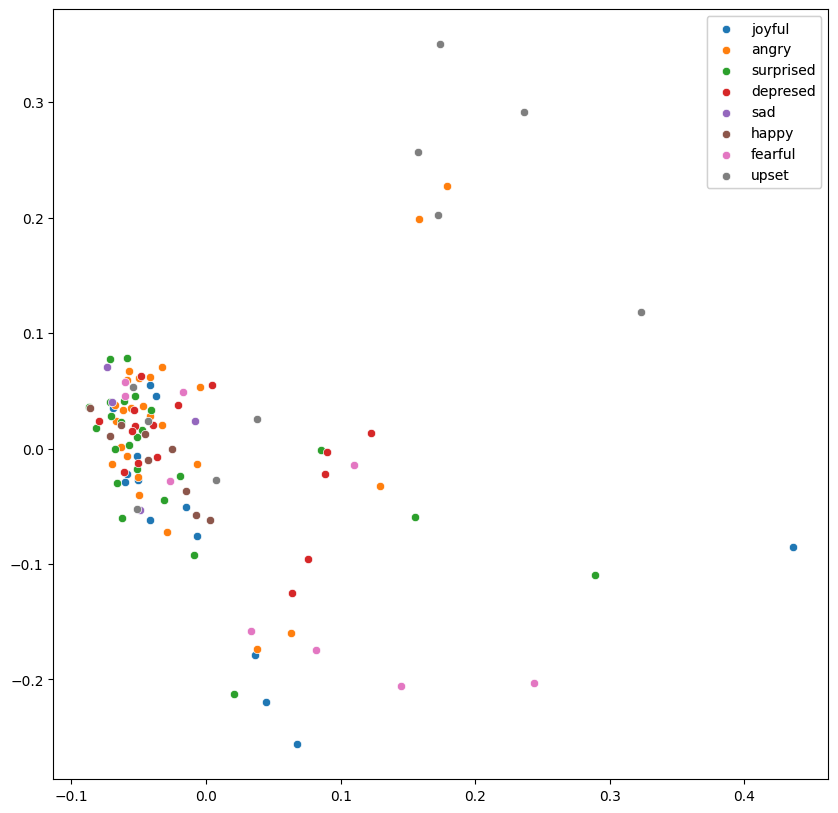

In [75]:
tmps = listdir("acted1") # current directory

#grp = { 'emotion' : [ [x1,x2] , [y1,y2] , color ] , ...}
grp = {}
for i in range(len(tmps)):
    tmp = tmps[i].split("_") # list of all names of files where are seperated by _
    #['ale', 'lift', 'an', '1', 'fin.csm']
    if tmp[-2] not in grp.keys():
         grp[tmp[-2]]=[[],[]]
    grp[tmp[-2]][0].append(pts[i][0])
    grp[tmp[-2]][1].append(pts[i][1])
fig = plt.figure(figsize=(10,10))
for i in range(len(grp.keys())):
    i = list(grp.keys())[i]
    ax = sns.scatterplot(x=grp[i][0], y=grp[i][1])
legend1 = ax.legend(grp.keys())
ax.add_artist(legend1)

Text(0.5, 1.0, 'Scattering into 8 clusters')

<Figure size 1000x1000 with 0 Axes>

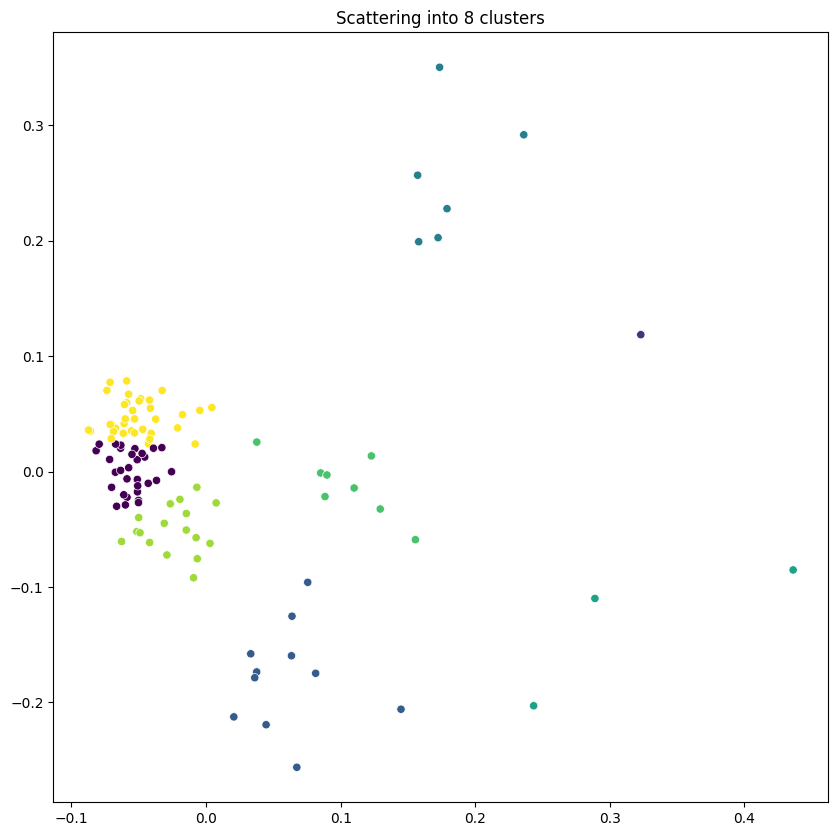

In [76]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=kmeans.labels_)
plt.title("Scattering into 8 clusters")

<h1>Evaluation

In [15]:
tmps = listdir("acted") # current directory
len(tmps)

179

In [ ]:
tmps = listdir("acted1") # current directory
ems = [] #TRUE emotions from file names
for i in tmps:
    ems.append(i.split("_")[-2])
em = np.unique(ems)

In [12]:

from itertools import permutations
comb_predd=[]
categories = em
label= list(kmeans.labels_)
labels = np.unique(label)
acc = []
kappa =[]
mcc = []
mappings = []
combinations = list(permutations(labels, len(labels)))

for combination in combinations:
    mapping = dict(zip(combination, categories))
    converted = [mapping[emo] for emo in label]
    comb_predd.append(converted)
    combbb = comb_predd[:20]
    for i in range(len(comb_predd[:12])):
        report_kmeans = metrics.classification_report(ems,comb_predd[i])
        accuracy =float(report_kmeans.split()[-14])
       
    acc.append(accuracy)
best_acc = max(acc)
best_acc

0.18

In [ ]:
for i in range(len(ems)):
    if ems[i]=='joyful':
        ems[i]= 0
    elif ems[i]=='angry':
        ems[i]= 1
    elif ems[i]=='surprised':
        ems[i]= 2
    elif ems[i]== 'depresed':
        ems[i]=3
    elif ems[i]== 'sad':
        ems[i]=4
    elif ems[i]== 'happy':
        ems[i]=5
    elif ems[i]== 'fearful':
        ems[i]=6
    elif ems[i]== 'upset':
        ems[i]=7

In [ ]:
prediction=list(kmeans.labels_)


In [ ]:
report_kmeans = metrics.classification_report(ems,prediction)
print(report_kmeans)

              precision    recall  f1-score   support

           0       0.13      0.29      0.18        14
           1       0.00      0.00      0.00        25
           2       0.09      0.04      0.06        24
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9
           6       0.06      0.11      0.08         9
           7       0.06      0.20      0.09        10

    accuracy                           0.07       111
   macro avg       0.04      0.08      0.05       111
weighted avg       0.05      0.07      0.05       111



visualisation of detailed rapport about the atribution of emotion-to-cluster that gives the best accuracy (the value of comb_emo to write manually) 

<h3> trying other clustering methods

<h4> clustering methods

In [17]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=8)
clusters_GM = model.fit_predict(pts)

In [18]:
prediction_GM=list(clusters_GM)
report_GM = metrics.classification_report(ems,prediction_GM)
print(report_GM)

              precision    recall  f1-score   support

           0       0.15      0.36      0.21        14
           1       0.15      0.08      0.11        25
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9
           6       0.09      0.33      0.14         9
           7       0.00      0.00      0.00        10

    accuracy                           0.09       111
   macro avg       0.05      0.10      0.06       111
weighted avg       0.06      0.09      0.06       111



In [19]:
from sklearn.cluster import Birch
model = Birch(threshold=0.01, n_clusters=8)
clusters_B = model.fit_predict(pts)

In [20]:
prediction_B=list(clusters_B)
report_B = metrics.classification_report(ems,prediction_B)
print(report_B)

              precision    recall  f1-score   support

           0       0.30      0.21      0.25        14
           1       0.33      0.08      0.13        25
           2       0.50      0.04      0.08        24
           3       0.16      0.69      0.27        16
           4       0.00      0.00      0.00         4
           5       0.19      0.33      0.24         9
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        10

    accuracy                           0.18       111
   macro avg       0.19      0.17      0.12       111
weighted avg       0.26      0.18      0.13       111



In [21]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=8)
clusters_SC = model.fit_predict(pts)

In [22]:
prediction_SC=list(clusters_SC)
report_SC = metrics.classification_report(ems,prediction_SC)
print(report_SC)

              precision    recall  f1-score   support

           0       0.29      0.71      0.42        14
           1       0.28      0.56      0.37        25
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9
           6       0.27      0.44      0.33         9
           7       0.50      0.10      0.17        10

    accuracy                           0.26       111
   macro avg       0.17      0.23      0.16       111
weighted avg       0.17      0.26      0.18       111



<h4> visualisation of the clusters

Text(0.5, 1.0, 'Scattering into 8 clusters')

<Figure size 1000x1000 with 0 Axes>

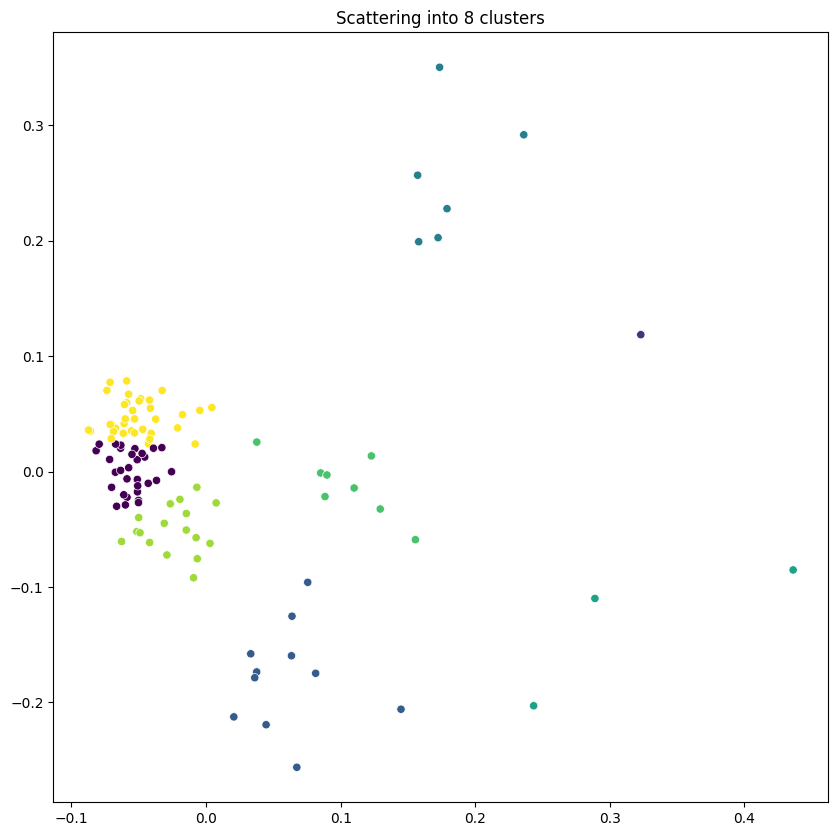

In [91]:
fig = plt.figure(figsize=(10,10))
X = []
Y = []
for i in range(len(pts)):
    X.append(pts[i][0])
    Y.append(pts[i][1])
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=X,y=Y,c=clusters)
plt.title("Scattering into 8 clusters")

definition of an evaluation method to use with any cluster

In [93]:
comb_emo = ems.copy()
len(comb_emo)

111

In [92]:
prediction=list(kmeans.labels_) 
report = metrics.classification_report(ems,prediction)
accuracy = float(report.split()[-14])
print('Accuracy',accuracy)

Accuracy 0.07


Evaluation

In [24]:
mcc_sc = metrics.matthews_corrcoef(ems,prediction_SC)
kappa_sc = metrics.cohen_kappa_score(ems,prediction_SC)
accuracy_sc =float(report_SC.split()[-14])
mcc_kmean = metrics.matthews_corrcoef(ems,prediction)
kappa_kmean = metrics.cohen_kappa_score(ems,prediction)
accuracy =float(report_kmeans.split()[-14])
mcc_b = metrics.matthews_corrcoef(ems,prediction_B)
kappa_b = metrics.cohen_kappa_score(ems,prediction_B)
accuracy_b =float(report_B.split()[-14])
mcc_gm = metrics.matthews_corrcoef(ems,prediction_GM)
kappa_gm = metrics.cohen_kappa_score(ems,prediction_GM)
accuracy_gm =float(report_GM.split()[-14])

In [29]:
data ={
       'Accuracy': [accuracy,accuracy_gm,accuracy_b,accuracy_sc],
       'Kappa score': [kappa_kmean,kappa_gm,kappa_b,kappa_sc],
       'Matthews corr coef':[mcc_kmean,mcc_gm,mcc_b,mcc_sc]}
df = pd.DataFrame(data)
df= df.set_index(pd.Index(['KMeans','Gausisan Mixture', 'Birch', 'Spectral Clustering']))
# df_kmeans = df.transpose()
df.to_csv('UCL_japan.csv')